In [1]:
import numpy as np 
import pandas as pd 

from sklearn.utils import resample # équilibrage de classes

# Préparation des données pour entrainement
from sklearn.model_selection import train_test_split

# Paramètres du modèle
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

# sauvegarde des hyperparamètres
import pickle

# Explicabilité
import shap

In [2]:
def load_data(filepath, drop_columns=None):
    """Charge les données depuis un fichier CSV et supprime les colonnes indésirées."""
    df = pd.read_csv(filepath)
    if drop_columns is not None:
        df = df.drop(columns=drop_columns)
    return df

def sort_dataset_by_patient_and_hour(df, patient_id_column='Patient_ID', hour_column='Hour'):
    """
    Trie le DataFrame en fonction des colonnes spécifiées pour Patient_ID et Hour, 
    assurant que les données sont triées d'abord par patient, puis par heure pour chaque patient.

    Args:
    df (DataFrame): Le DataFrame à trier.
    patient_id_column (str): Nom de la colonne contenant les identifiants des patients.
    hour_column (str): Nom de la colonne contenant les heures des prises de mesures.

    Returns:
    DataFrame: Un DataFrame trié selon les identifiants des patients et les heures.
    """
    sorted_df = df.sort_values(by=[patient_id_column, hour_column])
    return sorted_df


def aggregate_sepsis_label(df, patient_id_column='Patient_ID', sepsis_label_column='SepsisLabel'):
    """
    Agrège les données pour chaque patient pour déterminer si le patient a eu un sepsis
    à un moment quelconque et ajoute cette information dans une nouvelle colonne.

    Args:
    df (DataFrame): Le DataFrame contenant les données des patients.
    patient_id_column (str): Le nom de la colonne contenant les identifiants des patients.
    sepsis_label_column (str): Le nom de la colonne contenant les étiquettes de sepsis.

    Returns:
    DataFrame: Un DataFrame enrichi avec une colonne indiquant si le patient a eu un sepsis.
    """
    # Aggrégation des données par patient avec le maximum de SepsisLabel
    aggregated_df = df.groupby(patient_id_column)[sepsis_label_column].max().reset_index()

    # Renommer la colonne pour clarifier qu'il s'agit du résultat de l'aggrégation
    aggregated_df = aggregated_df.rename(columns={sepsis_label_column: 'will_have_sepsis'})

    # Joindre avec les données originales pour obtenir un DataFrame complet par patient
    aggregated_full_df = df.merge(aggregated_df, on=patient_id_column)

    return aggregated_full_df


def display_basic_info(df):
    """Affiche les informations de base sur le DataFrame, y compris sa forme, ses colonnes,
    un résumé descriptif, les valeurs manquantes par colonne et les premières lignes."""
    
    print("Shape of the DataFrame:", df.shape)
    print('\nNumbre of unique patients :', df['Patient_ID'].nunique())
    print("\nLignes classes counts : ", df['SepsisLabel'].value_counts())
    if 'will_have_sepsis' in df.columns:
        print('\nClasses counts : ', df['will_have_sepsis'].value_counts())
    print("\nColumns in the DataFrame:", df.columns)
    print("\nData Types:\n", df.dtypes)
    display("Descriptive Statistics:", df.describe())
    print("\nMissing Values Per Column:\n", df.isna().sum())
    display("First 5 Rows of the DataFrame:", df.head())
    
    


def clean_data(df, interest_columns=None, missing_value_threshold=0.3):
    """Nettoie le DataFrame en supprimant les lignes avec trop de valeurs manquantes.
    Si 'interest_columns' n'est pas spécifié, toutes les colonnes sont prises en compte."""
    
    if interest_columns is None:
        interest_columns = df.columns.tolist()
    seuil = missing_value_threshold * len(interest_columns)
    cleaned_df = df.dropna(subset=interest_columns, thresh=len(interest_columns) - seuil)
    return cleaned_df


def balance_classes(df, target_column, method='undersample', random_state=123):
    """
    Équilibre les classes dans un DataFrame en sous-échantillonnant la classe majoritaire ou 
    en sur-échantillonnant la classe minoritaire selon le paramètre 'method'.

    Args:
    df (DataFrame): Le DataFrame à équilibrer.
    target_column (str): Nom de la colonne contenant les étiquettes de classe.
    method (str): Méthode d'équilibrage, 'undersample' pour sous-échantillonnage ou 'oversample' pour sur-échantillonnage.
    random_state (int): Graine pour la génération de nombres aléatoires pour la reproductibilité.

    Returns:
    DataFrame: Un DataFrame où les classes sont équilibrées.
    """
    # Identifier les classes majoritaire et minoritaire
    class_counts = df[target_column].value_counts()
    major_class_label = class_counts.idxmax()
    minor_class_label = class_counts.idxmin()

    major_class = df[df[target_column] == major_class_label]
    minor_class = df[df[target_column] == minor_class_label]

    if method == 'undersample':
        # Sous-échantillonnage de la classe majoritaire
        resampled_major_class = resample(major_class,
                                         replace=False,
                                         n_samples=len(minor_class),
                                         random_state=random_state)
        balanced_df = pd.concat([resampled_major_class, minor_class])
    elif method == 'oversample':
        # Sur-échantillonnage de la classe minoritaire
        resampled_minor_class = resample(minor_class,
                                         replace=True,
                                         n_samples=len(major_class),
                                         random_state=random_state)
        balanced_df = pd.concat([major_class, resampled_minor_class])

    return balanced_df

def remove_pre_sepsis_rows(df, hours_before=6):
    """
    Supprime les lignes représentant les heures juste avant l'apparition du sepsis pour chaque patient.

    Args:
    df (DataFrame): DataFrame contenant les données des patients avec une colonne 'SepsisLabel'.
    hours_before (int): Nombre d'heures à supprimer avant l'apparition du sepsis.

    Returns:
    DataFrame: Un DataFrame avec les lignes spécifiées supprimées.
    """
    # Trouver les premiers indices de sepsis pour chaque patient
    first_sepsis_index = df[df['SepsisLabel'] == 1].groupby('Patient_ID').idxmin()['SepsisLabel']

    # Rassembler tous les indices à supprimer
    indices_to_remove = []
    for idx in first_sepsis_index:
        idx = int(idx)  # Assurer que idx est un entier
        # Trouver le début de l'enregistrement pour le patient
        patient_start_index = df[df['Patient_ID'] == df.at[idx, 'Patient_ID']].index[0]
        start_index = max(idx - hours_before, patient_start_index)
        indices_to_remove.extend(range(start_index, idx))

    # Supprimer les lignes
    df_dropped = df.drop(indices_to_remove)

    return df_dropped


In [3]:
file_path = 'Dataset.csv'
drop_columns = ['Unnamed: 0', 'Unit1', 'Unit2']
df = load_data(file_path, drop_columns)

In [4]:
# Affichage des informations de bases
display_basic_info(df)

Shape of the DataFrame: (1552210, 41)

Numbre of unique patients : 40336

Lignes classes counts :  SepsisLabel
0    1524294
1      27916
Name: count, dtype: int64

Columns in the DataFrame: Index(['Hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'HospAdmTime', 'ICULOS',
       'SepsisLabel', 'Patient_ID'],
      dtype='object')

Data Types:
 Hour                  int64
HR                  float64
O2Sat               float64
Temp                float64
SBP                 float64
MAP                 float64
DBP                 float64
Resp                float64
EtCO2               float64
BaseExcess          float64
HCO3            

'Descriptive Statistics:'

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,PTT,WBC,Fibrinogen,Platelets,Age,Gender,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
count,1.552210e+06,1.398811e+06,1.349474e+06,525226.000000,1.325945e+06,1.358940e+06,1.065656e+06,1.313875e+06,57636.000000,84145.000000,...,45699.000000,99447.000000,10242.000000,92209.000000,1.552210e+06,1.552210e+06,1.552202e+06,1.552210e+06,1.552210e+06,1.552210e+06
mean,2.549274e+01,8.458144e+01,9.719395e+01,36.977228,1.237505e+02,8.240010e+01,6.383056e+01,1.872650e+01,32.957657,-0.689919,...,41.231193,11.446405,287.385706,196.013911,6.200947e+01,5.592690e-01,-5.612512e+01,2.699499e+01,1.798468e-02,5.920148e+04
std,2.888256e+01,1.732524e+01,2.936924e+00,0.770014,2.323156e+01,1.634175e+01,1.395601e+01,5.098194e+00,7.951662,4.294297,...,26.217669,7.731013,153.002908,103.635366,1.638622e+01,4.964749e-01,1.622569e+02,2.900542e+01,1.328956e-01,5.024819e+04
min,0.000000e+00,2.000000e+01,2.000000e+01,20.900000,2.000000e+01,2.000000e+01,2.000000e+01,1.000000e+00,10.000000,-32.000000,...,12.500000,0.100000,34.000000,1.000000,1.400000e+01,0.000000e+00,-5.366860e+03,1.000000e+00,0.000000e+00,1.000000e+00
25%,9.000000e+00,7.200000e+01,9.600000e+01,36.500000,1.070000e+02,7.100000e+01,5.400000e+01,1.500000e+01,28.000000,-3.000000,...,27.800000,7.600000,184.000000,126.000000,5.168000e+01,0.000000e+00,-4.705000e+01,1.100000e+01,0.000000e+00,9.990000e+03
50%,1.900000e+01,8.350000e+01,9.800000e+01,37.000000,1.210000e+02,8.000000e+01,6.200000e+01,1.800000e+01,33.000000,0.000000,...,32.400000,10.300000,250.000000,181.000000,6.400000e+01,1.000000e+00,-6.030000e+00,2.100000e+01,0.000000e+00,1.996500e+04
75%,3.300000e+01,9.550000e+01,9.950000e+01,37.500000,1.380000e+02,9.200000e+01,7.200000e+01,2.150000e+01,38.000000,1.000000,...,42.800000,13.800000,349.000000,244.000000,7.400000e+01,1.000000e+00,-4.000000e-02,3.400000e+01,0.000000e+00,1.098780e+05
max,3.350000e+02,2.800000e+02,1.000000e+02,50.000000,3.000000e+02,3.000000e+02,3.000000e+02,1.000000e+02,100.000000,100.000000,...,250.000000,440.000000,1760.000000,2322.000000,1.000000e+02,1.000000e+00,2.399000e+01,3.360000e+02,1.000000e+00,1.200000e+05



Missing Values Per Column:
 Hour                      0
HR                   153399
O2Sat                202736
Temp                1026984
SBP                  226265
MAP                  193270
DBP                  486554
Resp                 238335
EtCO2               1494574
BaseExcess          1468065
HCO3                1487182
FiO2                1422845
pH                  1444637
PaCO2               1465909
SaO2                1498649
AST                 1527027
BUN                 1445642
Alkalinephos        1527269
Calcium             1460879
Chloride            1481744
Creatinine          1457594
Bilirubin_direct    1549220
Glucose             1286694
Lactate             1510764
Magnesium           1454259
Phosphate           1489909
Potassium           1407685
Bilirubin_total     1529069
TroponinI           1537429
Hct                 1414777
Hgb                 1437619
PTT                 1506511
WBC                 1452763
Fibrinogen          1541968
Platelets          

'First 5 Rows of the DataFrame:'

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,PTT,WBC,Fibrinogen,Platelets,Age,Gender,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,68.54,0,-0.02,1,0,17072
1,1,65.0,100.0,NaN,NaN,72.0,NaN,16.5,NaN,NaN,...,NaN,NaN,NaN,NaN,68.54,0,-0.02,2,0,17072
2,2,78.0,100.0,NaN,NaN,42.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,68.54,0,-0.02,3,0,17072
3,3,73.0,100.0,NaN,NaN,NaN,NaN,17.0,NaN,NaN,...,NaN,NaN,NaN,NaN,68.54,0,-0.02,4,0,17072
4,4,70.0,100.0,NaN,129.0,74.0,69.0,14.0,NaN,NaN,...,30.6,11.3,NaN,330.0,68.54,0,-0.02,5,0,17072


In [5]:
# Trie par patient and hour
df = sort_dataset_by_patient_and_hour(df)

# Aggrégation des données par patient avec le maximum de SepsisLabel
aggregate_df = aggregate_sepsis_label(df)

# Affichage des informations de bases
display_basic_info(aggregate_df)

Shape of the DataFrame: (1552210, 42)

Numbre of unique patients : 40336

Lignes classes counts :  SepsisLabel
0    1524294
1      27916
Name: count, dtype: int64

Classes counts :  will_have_sepsis
0    1379800
1     172410
Name: count, dtype: int64

Columns in the DataFrame: Index(['Hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'HospAdmTime', 'ICULOS',
       'SepsisLabel', 'Patient_ID', 'will_have_sepsis'],
      dtype='object')

Data Types:
 Hour                  int64
HR                  float64
O2Sat               float64
Temp                float64
SBP                 float64
MAP                 float64
DBP                 

'Descriptive Statistics:'

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,WBC,Fibrinogen,Platelets,Age,Gender,HospAdmTime,ICULOS,SepsisLabel,Patient_ID,will_have_sepsis
count,1.552210e+06,1.398811e+06,1.349474e+06,525226.000000,1.325945e+06,1.358940e+06,1.065656e+06,1.313875e+06,57636.000000,84145.000000,...,99447.000000,10242.000000,92209.000000,1.552210e+06,1.552210e+06,1.552202e+06,1.552210e+06,1.552210e+06,1.552210e+06,1.552210e+06
mean,2.549274e+01,8.458144e+01,9.719395e+01,36.977228,1.237505e+02,8.240010e+01,6.383056e+01,1.872650e+01,32.957657,-0.689919,...,11.446405,287.385706,196.013911,6.200947e+01,5.592690e-01,-5.612512e+01,2.699499e+01,1.798468e-02,5.920148e+04,1.110739e-01
std,2.888256e+01,1.732524e+01,2.936924e+00,0.770014,2.323156e+01,1.634175e+01,1.395601e+01,5.098194e+00,7.951662,4.294297,...,7.731013,153.002908,103.635366,1.638622e+01,4.964749e-01,1.622569e+02,2.900542e+01,1.328956e-01,5.024819e+04,3.142237e-01
min,0.000000e+00,2.000000e+01,2.000000e+01,20.900000,2.000000e+01,2.000000e+01,2.000000e+01,1.000000e+00,10.000000,-32.000000,...,0.100000,34.000000,1.000000,1.400000e+01,0.000000e+00,-5.366860e+03,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,9.000000e+00,7.200000e+01,9.600000e+01,36.500000,1.070000e+02,7.100000e+01,5.400000e+01,1.500000e+01,28.000000,-3.000000,...,7.600000,184.000000,126.000000,5.168000e+01,0.000000e+00,-4.705000e+01,1.100000e+01,0.000000e+00,9.990000e+03,0.000000e+00
50%,1.900000e+01,8.350000e+01,9.800000e+01,37.000000,1.210000e+02,8.000000e+01,6.200000e+01,1.800000e+01,33.000000,0.000000,...,10.300000,250.000000,181.000000,6.400000e+01,1.000000e+00,-6.030000e+00,2.100000e+01,0.000000e+00,1.996500e+04,0.000000e+00
75%,3.300000e+01,9.550000e+01,9.950000e+01,37.500000,1.380000e+02,9.200000e+01,7.200000e+01,2.150000e+01,38.000000,1.000000,...,13.800000,349.000000,244.000000,7.400000e+01,1.000000e+00,-4.000000e-02,3.400000e+01,0.000000e+00,1.098780e+05,0.000000e+00
max,3.350000e+02,2.800000e+02,1.000000e+02,50.000000,3.000000e+02,3.000000e+02,3.000000e+02,1.000000e+02,100.000000,100.000000,...,440.000000,1760.000000,2322.000000,1.000000e+02,1.000000e+00,2.399000e+01,3.360000e+02,1.000000e+00,1.200000e+05,1.000000e+00



Missing Values Per Column:
 Hour                      0
HR                   153399
O2Sat                202736
Temp                1026984
SBP                  226265
MAP                  193270
DBP                  486554
Resp                 238335
EtCO2               1494574
BaseExcess          1468065
HCO3                1487182
FiO2                1422845
pH                  1444637
PaCO2               1465909
SaO2                1498649
AST                 1527027
BUN                 1445642
Alkalinephos        1527269
Calcium             1460879
Chloride            1481744
Creatinine          1457594
Bilirubin_direct    1549220
Glucose             1286694
Lactate             1510764
Magnesium           1454259
Phosphate           1489909
Potassium           1407685
Bilirubin_total     1529069
TroponinI           1537429
Hct                 1414777
Hgb                 1437619
PTT                 1506511
WBC                 1452763
Fibrinogen          1541968
Platelets          

'First 5 Rows of the DataFrame:'

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,WBC,Fibrinogen,Platelets,Age,Gender,HospAdmTime,ICULOS,SepsisLabel,Patient_ID,will_have_sepsis
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,83.14,0,-0.03,1,0,1,0
1,1,97.0,95.0,NaN,98.0,75.33,NaN,19.0,NaN,NaN,...,NaN,NaN,NaN,83.14,0,-0.03,2,0,1,0
2,2,89.0,99.0,NaN,122.0,86.00,NaN,22.0,NaN,NaN,...,NaN,NaN,NaN,83.14,0,-0.03,3,0,1,0
3,3,90.0,95.0,NaN,NaN,NaN,NaN,30.0,NaN,24.0,...,NaN,NaN,NaN,83.14,0,-0.03,4,0,1,0
4,4,103.0,88.5,NaN,122.0,91.33,NaN,24.5,NaN,NaN,...,NaN,NaN,NaN,83.14,0,-0.03,5,0,1,0


In [20]:
df = remove_pre_sepsis_rows(aggregate_df)
df

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,WBC,Fibrinogen,Platelets,Age,Gender,HospAdmTime,ICULOS,SepsisLabel,Patient_ID,will_have_sepsis
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,83.14,0,-0.03,1,0,1,0
1,1,97.0,95.0,NaN,98.0,75.33,NaN,19.0,NaN,NaN,...,NaN,NaN,NaN,83.14,0,-0.03,2,0,1,0
2,2,89.0,99.0,NaN,122.0,86.00,NaN,22.0,NaN,NaN,...,NaN,NaN,NaN,83.14,0,-0.03,3,0,1,0
3,3,90.0,95.0,NaN,NaN,NaN,NaN,30.0,NaN,24.0,...,NaN,NaN,NaN,83.14,0,-0.03,4,0,1,0
4,4,103.0,88.5,NaN,122.0,91.33,NaN,24.5,NaN,NaN,...,NaN,NaN,NaN,83.14,0,-0.03,5,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1552205,30,80.0,96.0,NaN,115.0,87.00,65.0,15.0,NaN,NaN,...,NaN,NaN,NaN,62.00,0,0.00,31,0,120000,0
1552206,31,74.0,97.0,NaN,114.0,83.00,67.0,15.0,NaN,NaN,...,NaN,NaN,NaN,62.00,0,0.00,32,0,120000,0
1552207,32,78.0,98.0,NaN,110.0,83.00,69.0,15.0,NaN,NaN,...,NaN,NaN,NaN,62.00,0,0.00,33,0,120000,0
1552208,33,82.0,99.0,36.6,124.0,91.00,71.0,16.0,NaN,NaN,...,NaN,NaN,NaN,62.00,0,0.00,34,0,120000,0


In [7]:
def get_pre_sepsis_rows(df, hours_before=6):
    """
    Extrait les lignes représentant les heures juste avant l'apparition du sepsis pour chaque patient.

    Args:
    df (DataFrame): DataFrame contenant les données des patients avec une colonne 'SepsisLabel'.
    hours_before (int): Nombre d'heures à récupérer avant l'apparition du sepsis.

    Returns:
    DataFrame: Un DataFrame contenant uniquement les lignes des heures précédant le sepsis.
    """
    # Initialiser un DataFrame vide pour recueillir les lignes précédant le sepsis
    pre_sepsis_df = pd.DataFrame()

    # Itérer sur chaque groupe de patient
    for patient_id, group in df.groupby('Patient_ID'):
        # Trouver le premier indice où le sepsis apparaît
        sepsis_indices = group[group['SepsisLabel'] == 1].index
        
        if not sepsis_indices.empty:
            first_sepsis_index = sepsis_indices[0]
            # Calculer l'index de début pour les 6 heures avant l'apparition du sepsis
            start_index = max(first_sepsis_index - hours_before, group.index[0])

            # Extraire les lignes et les ajouter au DataFrame résultant
            pre_sepsis_rows = group.loc[start_index:first_sepsis_index - 1]
            pre_sepsis_df = pd.concat([pre_sepsis_df, pre_sepsis_rows])

    return pre_sepsis_df

# Utilisation de la fonction
df_pre_sepsis = get_pre_sepsis_rows(aggregate_df)

In [8]:
df_pre_sepsis['Patient_ID'].nunique()

2506

In [9]:
def subtract_dataframe(df, df_to_subtract):
    """
    Soustrait un sous-ensemble DataFrame d'un autre DataFrame en utilisant les indices des lignes.

    Args:
    df (DataFrame): DataFrame principal duquel les lignes seront supprimées.
    df_to_subtract (DataFrame): Sous-ensemble DataFrame dont les lignes seront soustraites de df.

    Returns:
    DataFrame: Le DataFrame résultant après la soustraction.
    """
    # Obtenir les indices des lignes à supprimer
    indices_to_drop = df_to_subtract.index

    # Supprimer ces lignes du DataFrame principal
    df_result = df.drop(indices_to_drop)

    return df_result


In [10]:
df_f = subtract_dataframe(aggregate_df, df_pre_sepsis)
df_f

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,WBC,Fibrinogen,Platelets,Age,Gender,HospAdmTime,ICULOS,SepsisLabel,Patient_ID,will_have_sepsis
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,83.14,0,-0.03,1,0,1,0
1,1,97.0,95.0,NaN,98.0,75.33,NaN,19.0,NaN,NaN,...,NaN,NaN,NaN,83.14,0,-0.03,2,0,1,0
2,2,89.0,99.0,NaN,122.0,86.00,NaN,22.0,NaN,NaN,...,NaN,NaN,NaN,83.14,0,-0.03,3,0,1,0
3,3,90.0,95.0,NaN,NaN,NaN,NaN,30.0,NaN,24.0,...,NaN,NaN,NaN,83.14,0,-0.03,4,0,1,0
4,4,103.0,88.5,NaN,122.0,91.33,NaN,24.5,NaN,NaN,...,NaN,NaN,NaN,83.14,0,-0.03,5,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1552205,30,80.0,96.0,NaN,115.0,87.00,65.0,15.0,NaN,NaN,...,NaN,NaN,NaN,62.00,0,0.00,31,0,120000,0
1552206,31,74.0,97.0,NaN,114.0,83.00,67.0,15.0,NaN,NaN,...,NaN,NaN,NaN,62.00,0,0.00,32,0,120000,0
1552207,32,78.0,98.0,NaN,110.0,83.00,69.0,15.0,NaN,NaN,...,NaN,NaN,NaN,62.00,0,0.00,33,0,120000,0
1552208,33,82.0,99.0,36.6,124.0,91.00,71.0,16.0,NaN,NaN,...,NaN,NaN,NaN,62.00,0,0.00,34,0,120000,0


In [12]:
# Appliquer d'abord une interpolation linéaire
df_f = df_f.groupby('Patient_ID').apply(lambda group: group.interpolate(method='linear'))
df_f

Hour     HR  O2Sat   Temp    SBP     MAP   DBP  Resp  \
Patient_ID                                                                 
1          0           0    NaN    NaN    NaN    NaN     NaN   NaN   NaN   
           1           1   97.0   95.0    NaN   98.0  75.330   NaN  19.0   
           2           2   89.0   99.0    NaN  122.0  86.000   NaN  22.0   
           3           3   90.0   95.0    NaN  122.0  88.665   NaN  30.0   
           4           4  103.0   88.5    NaN  122.0  91.330   NaN  24.5   
...                  ...    ...    ...    ...    ...     ...   ...   ...   
120000     1552205    30   80.0   96.0  36.45  115.0  87.000  65.0  15.0   
           1552206    31   74.0   97.0  36.50  114.0  83.000  67.0  15.0   
           1552207    32   78.0   98.0  36.55  110.0  83.000  69.0  15.0   
           1552208    33   82.0   99.0  36.60  124.0  91.000  71.0  16.0   
           1552209    34   80.0   97.0  36.60  121.0  97.000  73.0  15.0   

                    EtCO2  BaseExcess  ...  WBC  Fibrinogen  Platelets    Age  \
Patient_ID                             ...                                      
1          0          NaN         NaN  ...  NaN         NaN        NaN  83.14   
           1          NaN         NaN  ...  NaN         NaN        NaN  83.14   
           2          NaN         NaN  ...  NaN         NaN        NaN  83.14   
           3          NaN   24.000000  ...  NaN         NaN        NaN  83.14   
           4          NaN   23.857143  ...  NaN         NaN        NaN  83.14   
...                   ...         ...  ...  ...         ...        ...    ...   
120000     1552205    NaN         NaN  ...  5.4         NaN      216.0  62.00   
           1552206    NaN         NaN  ...  5.4         NaN      216.0  62.00   
           1552207    NaN         NaN  ...  5.4         NaN      216.0  62.00   
           1552208    NaN         NaN  ...  5.4         NaN      216.0  62.00   
           1552209    NaN         NaN  ...  5.4         NaN      216.0  62.00   

                    Gender  HospAdmTime  ICULOS  SepsisLabel  Patient_ID  \
Patient_ID                                                                 
1          0             0        -0.03       1            0           1   
           1             0        -0.03       2            0           1   
           2             0        -0.03       3            0           1   
           3             0        -0.03       4            0           1   
           4             0        -0.03       5            0           1   
...                    ...          ...     ...          ...         ...   
120000     1552205       0         0.00      31            0      120000   
           1552206       0         0.00      32            0      120000   
           1552207       0         0.00      33            0      120000   
           1552208       0         0.00      34            0      120000   
           1552209       0         0.00      35            0      120000   

                    will_have_sepsis  
Patient_ID                            
1          0                       0  
           1                       0  
           2                       0  
           3                       0  
           4                       0  
...                              ...  
120000     1552205                 0  
           1552206                 0  
           1552207                 0  
           1552208                 0  
           1552209                 0  

[1538131 rows x 42 columns]

In [13]:
df_f.isna().sum()

Hour                      0
HR                    35178
O2Sat                 37835
Temp                 114821
SBP                   59264
MAP                   42836
DBP                  317782
Resp                  47295
EtCO2               1409758
BaseExcess          1050672
HCO3                 872279
FiO2                 870496
pH                   842642
PaCO2                861701
SaO2                1076325
AST                 1070964
BUN                  318431
Alkalinephos        1075425
Calcium              440860
Chloride             827119
Creatinine           331581
Bilirubin_direct    1467293
Glucose              226485
Lactate             1083756
Magnesium            432288
Phosphate            662470
Potassium            282934
Bilirubin_total     1077011
TroponinI           1306714
Hct                  301883
Hgb                  325593
PTT                  852809
WBC                  349185
Fibrinogen          1374799
Platelets            346318
Age                 

In [14]:
# Utiliser ffill et bfill pour les valeurs manquantes restantes
df_f.fillna(method='ffill', inplace=True)
df_f.fillna(method='bfill', inplace=True)

In [15]:
df_f.isna().sum()

Hour                0
HR                  0
O2Sat               0
Temp                0
SBP                 0
MAP                 0
DBP                 0
Resp                0
EtCO2               0
BaseExcess          0
HCO3                0
FiO2                0
pH                  0
PaCO2               0
SaO2                0
AST                 0
BUN                 0
Alkalinephos        0
Calcium             0
Chloride            0
Creatinine          0
Bilirubin_direct    0
Glucose             0
Lactate             0
Magnesium           0
Phosphate           0
Potassium           0
Bilirubin_total     0
TroponinI           0
Hct                 0
Hgb                 0
PTT                 0
WBC                 0
Fibrinogen          0
Platelets           0
Age                 0
Gender              0
HospAdmTime         0
ICULOS              0
SepsisLabel         0
Patient_ID          0
will_have_sepsis    0
dtype: int64

In [20]:
df_f.drop(columns='level_1', inplace=True)


Hour     HR  O2Sat   Temp    SBP     MAP   DBP  Resp  \
Patient_ID                                                                 
1          0           0   97.0   95.0  36.11   98.0  75.330  43.0  19.0   
           1           1   97.0   95.0  36.11   98.0  75.330  43.0  19.0   
           2           2   89.0   99.0  36.11  122.0  86.000  43.0  22.0   
           3           3   90.0   95.0  36.11  122.0  88.665  43.0  30.0   
           4           4  103.0   88.5  36.11  122.0  91.330  43.0  24.5   
...                  ...    ...    ...    ...    ...     ...   ...   ...   
120000     1552205    30   80.0   96.0  36.45  115.0  87.000  65.0  15.0   
           1552206    31   74.0   97.0  36.50  114.0  83.000  67.0  15.0   
           1552207    32   78.0   98.0  36.55  110.0  83.000  69.0  15.0   
           1552208    33   82.0   99.0  36.60  124.0  91.000  71.0  16.0   
           1552209    34   80.0   97.0  36.60  121.0  97.000  73.0  15.0   

                    EtCO2  BaseExcess  ...  WBC  Fibrinogen  Platelets    Age  \
Patient_ID                             ...                                      
1          0         35.0   24.000000  ...  5.7       124.0      317.0  83.14   
           1         35.0   24.000000  ...  5.7       124.0      317.0  83.14   
           2         35.0   24.000000  ...  5.7       124.0      317.0  83.14   
           3         35.0   24.000000  ...  5.7       124.0      317.0  83.14   
           4         35.0   23.857143  ...  5.7       124.0      317.0  83.14   
...                   ...         ...  ...  ...         ...        ...    ...   
120000     1552205   45.0   -6.400000  ...  5.4       289.0      216.0  62.00   
           1552206   45.0   -6.400000  ...  5.4       289.0      216.0  62.00   
           1552207   45.0   -6.400000  ...  5.4       289.0      216.0  62.00   
           1552208   45.0   -6.400000  ...  5.4       289.0      216.0  62.00   
           1552209   45.0   -6.400000  ...  5.4       289.0      216.0  62.00   

                    Gender  HospAdmTime  ICULOS  SepsisLabel  Patient_ID  \
Patient_ID                                                                 
1          0             0        -0.03       1            0           1   
           1             0        -0.03       2            0           1   
           2             0        -0.03       3            0           1   
           3             0        -0.03       4            0           1   
           4             0        -0.03       5            0           1   
...                    ...          ...     ...          ...         ...   
120000     1552205       0         0.00      31            0      120000   
           1552206       0         0.00      32            0      120000   
           1552207       0         0.00      33            0      120000   
           1552208       0         0.00      34            0      120000   
           1552209       0         0.00      35            0      120000   

                    will_have_sepsis  
Patient_ID                            
1          0                       0  
           1                       0  
           2                       0  
           3                       0  
           4                       0  
...                              ...  
120000     1552205                 0  
           1552206                 0  
           1552207                 0  
           1552208                 0  
           1552209                 0  

[1538131 rows x 42 columns]

In [29]:
df.drop(columns='level_1', inplace=True)
df

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,WBC,Fibrinogen,Platelets,Age,Gender,HospAdmTime,ICULOS,SepsisLabel,Patient_ID,will_have_sepsis
0,0,97.0,95.0,36.11,98.0,75.330,43.0,19.0,35.0,24.000000,...,5.7,124.0,317.0,83.14,0,-0.03,1,0,1,0
1,1,97.0,95.0,36.11,98.0,75.330,43.0,19.0,35.0,24.000000,...,5.7,124.0,317.0,83.14,0,-0.03,2,0,1,0
2,2,89.0,99.0,36.11,122.0,86.000,43.0,22.0,35.0,24.000000,...,5.7,124.0,317.0,83.14,0,-0.03,3,0,1,0
3,3,90.0,95.0,36.11,122.0,88.665,43.0,30.0,35.0,24.000000,...,5.7,124.0,317.0,83.14,0,-0.03,4,0,1,0
4,4,103.0,88.5,36.11,122.0,91.330,43.0,24.5,35.0,23.857143,...,5.7,124.0,317.0,83.14,0,-0.03,5,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1538126,30,80.0,96.0,36.45,115.0,87.000,65.0,15.0,45.0,-6.400000,...,5.4,289.0,216.0,62.00,0,0.00,31,0,120000,0
1538127,31,74.0,97.0,36.50,114.0,83.000,67.0,15.0,45.0,-6.400000,...,5.4,289.0,216.0,62.00,0,0.00,32,0,120000,0
1538128,32,78.0,98.0,36.55,110.0,83.000,69.0,15.0,45.0,-6.400000,...,5.4,289.0,216.0,62.00,0,0.00,33,0,120000,0
1538129,33,82.0,99.0,36.60,124.0,91.000,71.0,16.0,45.0,-6.400000,...,5.4,289.0,216.0,62.00,0,0.00,34,0,120000,0


In [31]:
# Colonnes à placer en premier
priority_columns = ['Patient_ID', 'HospAdmTime', 'Age', 'Gender', 'Hour']

# Ajouter le reste des colonnes, en excluant celles déjà listées
remaining_columns = [col for col in df.columns if col not in priority_columns]

# Combiner les listes pour former l'ordre final des colonnes
final_columns = priority_columns + remaining_columns
df = df[final_columns]
df

,Patient_ID,HospAdmTime,Age,Gender,Hour,HR,O2Sat,Temp,SBP,MAP,...,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,ICULOS,SepsisLabel,will_have_sepsis
0,1,-0.03,83.14,0,0,97.0,95.0,36.11,98.0,75.330,...,0.70,37.2,12.5,30.5,5.7,124.0,317.0,1,0,0
1,1,-0.03,83.14,0,1,97.0,95.0,36.11,98.0,75.330,...,0.70,37.2,12.5,30.5,5.7,124.0,317.0,2,0,0
2,1,-0.03,83.14,0,2,89.0,99.0,36.11,122.0,86.000,...,0.70,37.2,12.5,30.5,5.7,124.0,317.0,3,0,0
3,1,-0.03,83.14,0,3,90.0,95.0,36.11,122.0,88.665,...,0.70,37.2,12.5,30.5,5.7,124.0,317.0,4,0,0
4,1,-0.03,83.14,0,4,103.0,88.5,36.11,122.0,91.330,...,0.70,37.2,12.5,30.5,5.7,124.0,317.0,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1538126,120000,0.00,62.00,0,30,80.0,96.0,36.45,115.0,87.000,...,1.09,37.1,11.6,29.1,5.4,289.0,216.0,31,0,0
1538127,120000,0.00,62.00,0,31,74.0,97.0,36.50,114.0,83.000,...,1.09,37.1,11.6,29.1,5.4,289.0,216.0,32,0,0
1538128,120000,0.00,62.00,0,32,78.0,98.0,36.55,110.0,83.000,...,1.09,37.1,11.6,29.1,5.4,289.0,216.0,33,0,0
1538129,120000,0.00,62.00,0,33,82.0,99.0,36.60,124.0,91.000,...,1.09,37.1,11.6,29.1,5.4,289.0,216.0,34,0,0


In [32]:
df.to_csv('df_final.csv')

In [33]:
df.drop(columns='SepsisLabel', inplace=True)

C:\Users\AdminPC\AppData\Local\Temp\ipykernel_10416\3972720344.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns='SepsisLabel', inplace=True)


In [37]:
X_train, X_test, y_train, y_test = prepare_train_test(balanced_df, 'will_have_sepsis')

X_train: (253329, 40) X_test: (63333, 40) y_train: (253329,) y_test: (63333,)


In [39]:
# Calcule des meilleurs hyperparamètres
best_params, study = perform_hyperparameter_optimization(X_train, y_train, objective, n_trials=50)
print("Meilleurs hyperparamètres:", best_params)
study_filename = 'optuna_study_v3.pkl'
save_study(study, study_filename)

[I 2024-07-22 21:35:12,864] A new study created in memory with name: no-name-b1b90547-c4aa-4141-8965-33e86c78361e
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_10416\1855230305.py:47: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_10416\1855230305.py:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_10416\1855230305.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

[I 2024-07-22 21:40:47,057] Trial 6 finished with value: 0.8090348842783818 and parameters: {'learning_rate': 0.31156763148163696, 'max_depth': 3, 'n_estimators': 187, 'min_child_weight': 5, 'gamma': 0.6189707918754463, 'subsample': 0.5002251410101575}. Best is trial 1 with value: 0.9770496047607322.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_10416\1855230305.py:47: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_10416\1855230305.py:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_10416\1855230305.py:52

[I 2024-07-22 21:48:13,913] Trial 13 finished with value: 0.9664823171509572 and parameters: {'learning_rate': 0.18947995257070885, 'max_depth': 8, 'n_estimators': 238, 'min_child_weight': 8, 'gamma': 2.1733942540313906, 'subsample': 0.9393079224582654}. Best is trial 12 with value: 0.987407679418619.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_10416\1855230305.py:47: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_10416\1855230305.py:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_10416\1855230305.py:5

[I 2024-07-22 21:56:55,037] Trial 20 finished with value: 0.9429556018113507 and parameters: {'learning_rate': 0.9646105346403706, 'max_depth': 6, 'n_estimators': 195, 'min_child_weight': 1, 'gamma': 2.1656328927529582, 'subsample': 0.4361475620745747}. Best is trial 12 with value: 0.987407679418619.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_10416\1855230305.py:47: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_10416\1855230305.py:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_10416\1855230305.py:52

[I 2024-07-22 22:06:11,891] Trial 27 finished with value: 0.9777798807998164 and parameters: {'learning_rate': 0.35962191664478804, 'max_depth': 11, 'n_estimators': 230, 'min_child_weight': 2, 'gamma': 1.9144305638730912, 'subsample': 0.6076981931082801}. Best is trial 12 with value: 0.987407679418619.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_10416\1855230305.py:47: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_10416\1855230305.py:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_10416\1855230305.py:

[I 2024-07-22 22:21:27,217] Trial 34 finished with value: 0.9872339892140951 and parameters: {'learning_rate': 0.07996967130043031, 'max_depth': 15, 'n_estimators': 182, 'min_child_weight': 2, 'gamma': 0.35597981570920645, 'subsample': 0.7274783104557787}. Best is trial 12 with value: 0.987407679418619.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_10416\1855230305.py:47: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_10416\1855230305.py:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_10416\1855230305.py

[I 2024-07-22 22:40:47,462] Trial 41 finished with value: 0.98832348214218 and parameters: {'learning_rate': 0.08066070697984634, 'max_depth': 15, 'n_estimators': 208, 'min_child_weight': 2, 'gamma': 0.3492960188602986, 'subsample': 0.9072579119006179}. Best is trial 41 with value: 0.98832348214218.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_10416\1855230305.py:47: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_10416\1855230305.py:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_10416\1855230305.py:52:

[I 2024-07-22 22:49:44,884] Trial 48 finished with value: 0.9673941636188472 and parameters: {'learning_rate': 0.32572227294384287, 'max_depth': 14, 'n_estimators': 168, 'min_child_weight': 6, 'gamma': 3.585318014434935, 'subsample': 0.9318613830610823}. Best is trial 41 with value: 0.98832348214218.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_10416\1855230305.py:47: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_10416\1855230305.py:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_10416\1855230305.py:52

Meilleurs hyperparamètres: {'learning_rate': 0.08066070697984634, 'max_depth': 15, 'n_estimators': 208, 'min_child_weight': 2, 'gamma': 0.3492960188602986, 'subsample': 0.9072579119006179}


In [40]:
# Entrainement du modèle avec les meilleurs hyperparamètres calculés
model_path = 'xgboost_model_v3.joblib'
xgbc_model = train_and_save_xgboost_classifier(X_train, y_train, best_params, model_path)

In [41]:
# Prédiction et évaluation
evaluation_report = predict_and_evaluate(xgbc_model, X_test, y_test)
print(evaluation_report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     31667
           1       0.99      0.99      0.99     31666

    accuracy                           0.99     63333
   macro avg       0.99      0.99      0.99     63333
weighted avg       0.99      0.99      0.99     63333



In [43]:
X_test['Patient_ID'].nunique()

23426

100%|===================| 63326/63333 [85:36<00:00]        

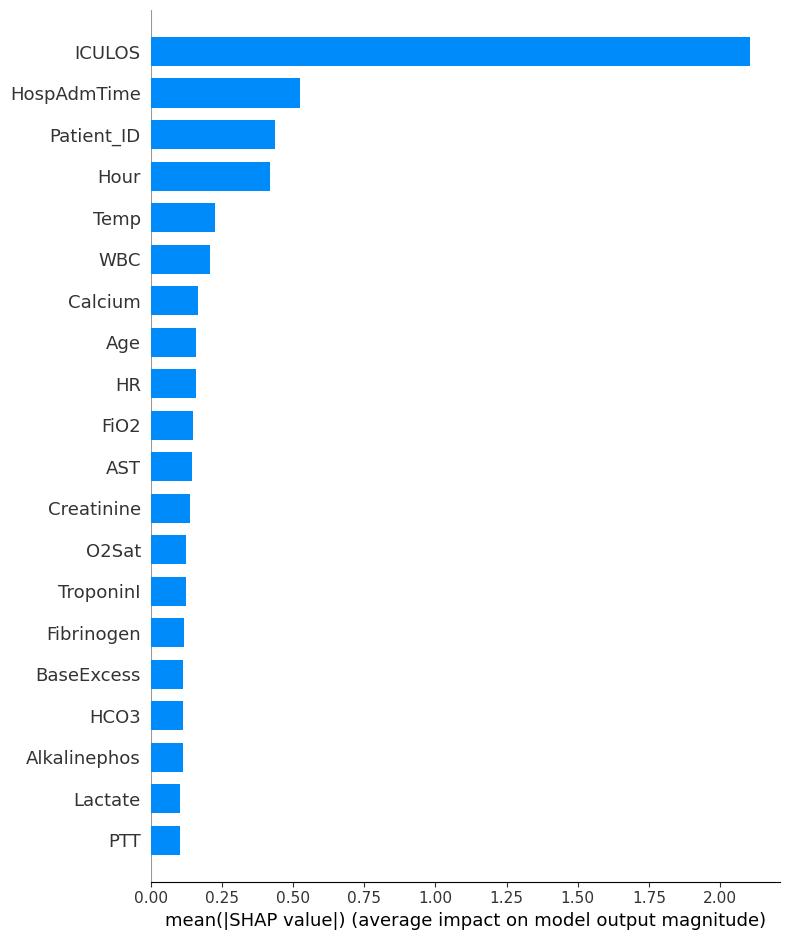

In [44]:
# Affichage du résultat de SHAP
explain_model_predictions_with_shap(xgbc_model, X_train, X_test)

In [47]:
def split_train_test_data(df, test_size=0.2, random_seed=42):
    """
    Sépare les données en ensembles d'entraînement et de test, en s'assurant que les patients
    avec et sans sepsis sont correctement répartis sans chevauchement entre les ensembles.

    Args:
    df (DataFrame): Le DataFrame contenant les données des patients.
    test_size (float): La proportion de chaque groupe de patients à utiliser pour le test.
    random_seed (int): La graine pour la génération de nombres aléatoires pour la reproductibilité.

    Returns:
    tuple: Un tuple contenant deux DataFrames, (train_df, test_df).
    """
    np.random.seed(random_seed)  # Pour la reproductibilité

    # Identifier les patients qui ont eu un sepsis
    patients_with_sepsis = df[df['will_have_sepsis'] == 1]['Patient_ID'].unique()

    # Sélectionner une proportion pour le test parmi les patients avec sepsis
    test_patients_with_sepsis = np.random.choice(patients_with_sepsis, size=int(len(patients_with_sepsis) * test_size), replace=False)

    # Identifier et sélectionner une proportion pour le test parmi les patients sans sepsis
    patients_without_sepsis = df[df['will_have_sepsis'] == 0]['Patient_ID'].unique()
    test_patients_without_sepsis = np.random.choice(patients_without_sepsis, size=int(len(patients_without_sepsis) * test_size), replace=False)

    # Combiner les patients de test
    test_patients = np.concatenate((test_patients_with_sepsis, test_patients_without_sepsis))

    # Créer les ensembles de données
    train_df = df[~df['Patient_ID'].isin(test_patients)]
    test_df = df[df['Patient_ID'].isin(test_patients)]

    return train_df, test_df


In [70]:
def add_time_to_sepsis_column(df):
    # Ajouter une colonne initialement remplie de NA
    df['time_to_sepsis'] = pd.NA
    
    # Itérer sur chaque groupe de patients
    for pid, group in df.groupby('Patient_ID'):
        # Trouver le premier indice où SepsisLabel passe à 1
        sepsis_indices = group[group['SepsisLabel'] == 1].index
        if not sepsis_indices.empty:
            first_sepsis_index = sepsis_indices[0]
            sepsis_hour = group.at[first_sepsis_index, 'Hour']
            # Calculer time_to_sepsis pour toutes les lignes du patient
            df.loc[df['Patient_ID'] == pid, 'time_to_sepsis'] = sepsis_hour - df.loc[df['Patient_ID'] == pid, 'Hour']
    
    display(df)
    print(df.shape)
    print(df['Patient_ID'].nunique())
    
    return df

# Assumer que df est votre DataFrame contenant la colonne 'time_to_sepsis'
def remove_rows_before_sepsis(df, time_window=6):
    """
    Supprime les lignes du DataFrame où la valeur de 'time_to_sepsis' est inférieure à 6.
    
    Args:
    df (DataFrame): Le DataFrame contenant les données des patients.

    Returns:
    DataFrame: Un DataFrame avec les lignes désirées supprimées.
    """
    # Filtrer le DataFrame pour conserver seulement les lignes avec 'time_to_sepsis' >= 6
    filtered_df = df[df['time_to_sepsis'] >= time_window]
    return filtered_df

In [59]:

# df = pd.read_csv('df_final.csv')
df.drop(columns='Unnamed: 0', inplace=True)
print(df.head())
df_train, df_test = split_train_test_data(df)



   Patient_ID  HospAdmTime    Age  Gender  Hour     HR  O2Sat   Temp    SBP  \
0           1        -0.03  83.14       0     0   97.0   95.0  36.11   98.0   
1           1        -0.03  83.14       0     1   97.0   95.0  36.11   98.0   
2           1        -0.03  83.14       0     2   89.0   99.0  36.11  122.0   
3           1        -0.03  83.14       0     3   90.0   95.0  36.11  122.0   
4           1        -0.03  83.14       0     4  103.0   88.5  36.11  122.0   

      MAP  ...  TroponinI   Hct   Hgb   PTT  WBC  Fibrinogen  Platelets  \
0  75.330  ...        0.7  37.2  12.5  30.5  5.7       124.0      317.0   
1  75.330  ...        0.7  37.2  12.5  30.5  5.7       124.0      317.0   
2  86.000  ...        0.7  37.2  12.5  30.5  5.7       124.0      317.0   
3  88.665  ...        0.7  37.2  12.5  30.5  5.7       124.0      317.0   
4  91.330  ...        0.7  37.2  12.5  30.5  5.7       124.0      317.0   

   ICULOS  SepsisLabel  will_have_sepsis  
0       1            0         

In [60]:
print(df.shape)
print(df_train.shape)
print(df_test.shape)

(1538131, 42)
(1227392, 42)
(310739, 42)


In [61]:
print(df_test['Patient_ID'].nunique())
print(df_train['Patient_ID'].nunique())

8066
32270


In [62]:
display(df_test.head(15))

,Patient_ID,HospAdmTime,Age,Gender,Hour,HR,O2Sat,Temp,SBP,MAP,...,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,ICULOS,SepsisLabel,will_have_sepsis
54,2,-98.6,75.91,0,0,84.0,85.0,36.3300,78.0,44.0,...,0.7,36.2,12.2,30.5,14.7,124.0,338.0,1,0,0
55,2,-98.6,75.91,0,1,61.0,99.0,36.4400,124.0,65.0,...,0.7,36.2,12.2,30.5,14.7,124.0,338.0,2,0,0
56,2,-98.6,75.91,0,2,64.0,98.0,36.3850,125.0,64.0,...,0.7,36.2,12.2,30.5,14.7,124.0,338.0,3,0,0
57,2,-98.6,75.91,0,3,56.0,100.0,36.3300,123.0,65.0,...,0.7,36.2,12.2,30.5,14.7,124.0,338.0,4,0,0
58,2,-98.6,75.91,0,4,66.0,99.0,36.2750,120.0,67.0,...,0.7,36.2,12.2,30.5,14.7,124.0,338.0,5,0,0
59,2,-98.6,75.91,0,5,94.0,100.0,36.2200,194.0,116.0,...,0.7,36.2,12.2,30.5,14.7,124.0,338.0,6,0,0
60,2,-98.6,75.91,0,6,58.0,99.0,36.1925,133.0,68.0,...,0.7,36.2,12.2,30.5,14.7,124.0,338.0,7,0,0
61,2,-98.6,75.91,0,7,57.0,100.0,36.1650,118.0,62.0,...,0.7,36.2,12.2,30.5,14.7,124.0,338.0,8,0,0
62,2,-98.6,75.91,0,8,62.0,100.0,36.1375,126.0,66.0,...,0.7,36.2,12.2,30.5,14.7,124.0,338.0,9,0,0
63,2,-98.6,75.91,0,9,58.0,95.0,36.1100,143.0,77.0,...,0.7,27.8,9.7,30.5,11.0,124.0,158.0,10,0,0


In [63]:
df_test_with_sepsis = df_test[df_test['will_have_sepsis'] == 1]

In [66]:
df_test_with_sepsis

,Patient_ID,HospAdmTime,Age,Gender,Hour,HR,O2Sat,Temp,SBP,MAP,...,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,ICULOS,SepsisLabel,will_have_sepsis
2329,64,-0.01,68.98,0,0,82.000000,100.0,37.72,118.000000,104.000000,...,8.50,28.000000,9.300000,29.900000,13.600000,220.0,131.000000,2,0,1
2330,64,-0.01,68.98,0,1,84.000000,100.0,37.71,97.000000,77.670000,...,8.50,28.000000,9.300000,29.900000,13.600000,220.0,131.000000,3,0,1
2331,64,-0.01,68.98,0,2,68.000000,100.0,37.70,99.000000,66.000000,...,8.50,27.000000,9.500000,25.600000,10.100000,309.0,190.000000,4,0,1
2332,64,-0.01,68.98,0,3,73.000000,100.0,37.69,97.000000,63.000000,...,8.50,26.754545,9.452632,25.778947,10.136842,309.0,187.157895,5,0,1
2333,64,-0.01,68.98,0,4,77.000000,100.0,37.68,94.000000,63.000000,...,8.50,26.509091,9.405263,25.957895,10.173684,309.0,184.315789,6,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1533627,119884,-0.08,47.00,1,235,77.714286,99.6,37.12,95.444444,72.777778,...,0.11,28.150000,9.400000,37.500000,12.400000,323.0,103.000000,236,1,1
1533628,119884,-0.08,47.00,1,236,76.857143,99.8,37.16,97.222222,72.888889,...,0.11,29.000000,9.800000,35.833333,12.400000,323.0,119.000000,237,1,1
1533629,119884,-0.08,47.00,1,237,76.000000,100.0,37.20,99.000000,73.000000,...,0.11,32.500000,10.750000,34.166667,12.400000,323.0,135.000000,238,1,1
1533630,119884,-0.08,47.00,1,238,73.000000,100.0,37.10,91.000000,73.000000,...,0.11,36.000000,11.700000,32.500000,12.400000,323.0,151.000000,239,1,1


In [67]:
df_t = add_time_to_sepsis_column(df_test_with_sepsis)

C:\Users\AdminPC\AppData\Local\Temp\ipykernel_10416\3074571879.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time_to_sepsis'] = pd.NA


,Patient_ID,HospAdmTime,Age,Gender,Hour,HR,O2Sat,Temp,SBP,MAP,...,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,ICULOS,SepsisLabel,will_have_sepsis,time_to_sepsis
2329,64,-0.01,68.98,0,0,82.000000,100.0,37.72,118.000000,104.000000,...,28.000000,9.300000,29.900000,13.600000,220.0,131.000000,2,0,1,19
2330,64,-0.01,68.98,0,1,84.000000,100.0,37.71,97.000000,77.670000,...,28.000000,9.300000,29.900000,13.600000,220.0,131.000000,3,0,1,18
2331,64,-0.01,68.98,0,2,68.000000,100.0,37.70,99.000000,66.000000,...,27.000000,9.500000,25.600000,10.100000,309.0,190.000000,4,0,1,17
2332,64,-0.01,68.98,0,3,73.000000,100.0,37.69,97.000000,63.000000,...,26.754545,9.452632,25.778947,10.136842,309.0,187.157895,5,0,1,16
2333,64,-0.01,68.98,0,4,77.000000,100.0,37.68,94.000000,63.000000,...,26.509091,9.405263,25.957895,10.173684,309.0,184.315789,6,0,1,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1533627,119884,-0.08,47.00,1,235,77.714286,99.6,37.12,95.444444,72.777778,...,28.150000,9.400000,37.500000,12.400000,323.0,103.000000,236,1,1,-5
1533628,119884,-0.08,47.00,1,236,76.857143,99.8,37.16,97.222222,72.888889,...,29.000000,9.800000,35.833333,12.400000,323.0,119.000000,237,1,1,-6
1533629,119884,-0.08,47.00,1,237,76.000000,100.0,37.20,99.000000,73.000000,...,32.500000,10.750000,34.166667,12.400000,323.0,135.000000,238,1,1,-7
1533630,119884,-0.08,47.00,1,238,73.000000,100.0,37.10,91.000000,73.000000,...,36.000000,11.700000,32.500000,12.400000,323.0,151.000000,239,1,1,-8


(33421, 43)
586


In [68]:
df_t.iloc[10:20]

,Patient_ID,HospAdmTime,Age,Gender,Hour,HR,O2Sat,Temp,SBP,MAP,...,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,ICULOS,SepsisLabel,will_have_sepsis,time_to_sepsis
2339,64,-0.01,68.98,0,10,81.0,100.0,37.5000,114.0,72.0,...,25.036364,9.121053,27.031579,10.394737,309.0,167.263158,12,0,1,9
2340,64,-0.01,68.98,0,11,80.0,100.0,37.4150,158.0,84.0,...,24.790909,9.073684,27.210526,10.431579,309.0,164.421053,13,0,1,8
2341,64,-0.01,68.98,0,12,97.0,99.0,37.3300,140.0,65.0,...,24.545455,9.026316,27.389474,10.468421,309.0,161.578947,14,0,1,7
2342,64,-0.01,68.98,0,19,96.0,100.0,37.4150,147.0,86.0,...,24.300000,8.978947,27.568421,10.505263,309.0,158.736842,21,1,1,0
2343,64,-0.01,68.98,0,20,92.0,100.0,37.5000,140.0,82.0,...,24.512500,8.931579,27.747368,10.542105,309.0,155.894737,22,1,1,-1
2344,64,-0.01,68.98,0,21,92.0,100.0,37.4575,102.0,63.0,...,24.725000,8.884211,27.926316,10.578947,309.0,153.052632,23,1,1,-2
2345,64,-0.01,68.98,0,22,93.0,100.0,37.4150,118.0,74.0,...,24.937500,8.836842,28.105263,10.615789,309.0,150.210526,24,1,1,-3
2346,64,-0.01,68.98,0,23,91.0,100.0,37.3725,108.0,67.0,...,25.150000,8.789474,28.284211,10.652632,309.0,147.368421,25,1,1,-4
2347,64,-0.01,68.98,0,24,94.0,100.0,37.3300,110.0,68.0,...,25.362500,8.742105,28.463158,10.689474,309.0,144.526316,26,1,1,-5
2348,64,-0.01,68.98,0,25,83.0,100.0,37.3300,128.0,83.0,...,25.575000,8.694737,28.642105,10.726316,309.0,141.684211,27,1,1,-6


In [74]:
# df_test_filtred.to_csv('df_test_sepsis_6h.csv', index=False)

In [75]:
# df_test_filtred = remove_rows_before_sepsis(df_t)
df_test_filtred.drop(columns='time_to_sepsis', inplace=True)
df_test_filtred.head(15)

C:\Users\AdminPC\AppData\Local\Temp\ipykernel_10416\3615414260.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_filtred.drop(columns='time_to_sepsis', inplace=True)


,Patient_ID,HospAdmTime,Age,Gender,Hour,HR,O2Sat,Temp,SBP,MAP,...,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,ICULOS,SepsisLabel,will_have_sepsis
2329,64,-0.01,68.98,0,0,82.0,100.0,37.720,118.0,104.00,...,8.5,28.000000,9.300000,29.900000,13.600000,220.0,131.000000,2,0,1
2330,64,-0.01,68.98,0,1,84.0,100.0,37.710,97.0,77.67,...,8.5,28.000000,9.300000,29.900000,13.600000,220.0,131.000000,3,0,1
2331,64,-0.01,68.98,0,2,68.0,100.0,37.700,99.0,66.00,...,8.5,27.000000,9.500000,25.600000,10.100000,309.0,190.000000,4,0,1
2332,64,-0.01,68.98,0,3,73.0,100.0,37.690,97.0,63.00,...,8.5,26.754545,9.452632,25.778947,10.136842,309.0,187.157895,5,0,1
2333,64,-0.01,68.98,0,4,77.0,100.0,37.680,94.0,63.00,...,8.5,26.509091,9.405263,25.957895,10.173684,309.0,184.315789,6,0,1
2334,64,-0.01,68.98,0,5,77.5,100.0,37.670,99.5,62.50,...,8.5,26.263636,9.357895,26.136842,10.210526,309.0,181.473684,7,0,1
2335,64,-0.01,68.98,0,6,81.0,100.0,37.670,124.0,75.00,...,8.5,26.018182,9.310526,26.315789,10.247368,309.0,178.631579,8,0,1
2336,64,-0.01,68.98,0,7,83.0,100.0,37.670,150.0,85.00,...,8.5,25.772727,9.263158,26.494737,10.284211,309.0,175.789474,9,0,1
2337,64,-0.01,68.98,0,8,74.0,100.0,37.670,95.5,55.00,...,8.5,25.527273,9.215789,26.673684,10.321053,309.0,172.947368,10,0,1
2338,64,-0.01,68.98,0,9,87.0,100.0,37.585,161.0,102.00,...,8.5,25.281818,9.168421,26.852632,10.357895,309.0,170.105263,11,0,1


In [76]:
print(df_test_filtred.shape)

(27790, 42)


In [78]:
# Extraire les patients de test qui ne vont pas développer le sepsis
df_test_without_sepsis = df_test[df_test['will_have_sepsis'] == 0]

# Concaténer le DataFrame filtré avec le DataFrame des patients sans sepsis
df_test_final_6H = pd.concat([df_test_filtred, df_test_without_sepsis], ignore_index=True)
df_test_final_6H

,Patient_ID,HospAdmTime,Age,Gender,Hour,HR,O2Sat,Temp,SBP,MAP,...,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,ICULOS,SepsisLabel,will_have_sepsis
0,64,-0.01,68.98,0,0,82.0,100.0,37.72,118.0,104.00,...,8.50,28.000000,9.300000,29.900000,13.600000,220.0,131.000000,2,0,1
1,64,-0.01,68.98,0,1,84.0,100.0,37.71,97.0,77.67,...,8.50,28.000000,9.300000,29.900000,13.600000,220.0,131.000000,3,0,1
2,64,-0.01,68.98,0,2,68.0,100.0,37.70,99.0,66.00,...,8.50,27.000000,9.500000,25.600000,10.100000,309.0,190.000000,4,0,1
3,64,-0.01,68.98,0,3,73.0,100.0,37.69,97.0,63.00,...,8.50,26.754545,9.452632,25.778947,10.136842,309.0,187.157895,5,0,1
4,64,-0.01,68.98,0,4,77.0,100.0,37.68,94.0,63.00,...,8.50,26.509091,9.405263,25.957895,10.173684,309.0,184.315789,6,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305103,119997,-0.02,30.00,1,20,46.0,97.0,37.30,156.0,110.00,...,1.09,44.000000,15.000000,38.200000,10.000000,289.0,177.000000,21,0,0
305104,119997,-0.02,30.00,1,21,46.0,98.0,37.30,145.0,104.00,...,1.09,44.000000,15.000000,38.200000,10.000000,289.0,177.000000,22,0,0
305105,119997,-0.02,30.00,1,22,52.0,98.0,37.30,123.0,93.00,...,1.09,44.000000,15.000000,38.200000,10.000000,289.0,177.000000,23,0,0
305106,119997,-0.02,30.00,1,23,64.0,97.0,37.30,103.0,78.00,...,1.09,44.000000,15.000000,38.200000,10.000000,289.0,177.000000,24,0,0


In [80]:
# df_test_final_6H.to_csv('df_test_final_6H.csv', index=False)
# df_train.to_csv('df_Train_final_6H.csv', index=False)

In [81]:
df_test_final_6H.drop(columns='SepsisLabel', inplace=True)
df_train.drop(columns='SepsisLabel', inplace=True)
print(df_test_final_6H.shape)
print(df_train.shape)

(305108, 41)
(1227392, 41)


C:\Users\AdminPC\AppData\Local\Temp\ipykernel_10416\390549712.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(columns='SepsisLabel', inplace=True)


In [87]:
# Équilibrage de classes

df_undersample = balance_classes(df_train, 'will_have_sepsis')
df_undersample

,Patient_ID,HospAdmTime,Age,Gender,Hour,HR,O2Sat,Temp,SBP,MAP,...,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,ICULOS,will_have_sepsis
825240,101141,-28.44,77.0,0,15,80.0,95.0,38.6000,105.0,76.0,...,1.9,0.01,27.20,9.388889,94.80,26.233333,159.916667,98.444444,17,0
1282522,113252,0.00,52.0,0,46,96.0,100.0,37.8500,200.0,130.0,...,1.8,1.43,31.70,10.900000,33.10,7.600000,158.000000,244.000000,47,0
1286735,113369,-150.04,85.0,0,19,85.0,100.0,36.3625,132.0,94.0,...,0.6,1.43,32.52,8.687500,37.50,5.680000,226.000000,171.400000,20,0
920343,103712,-181.36,68.0,1,13,88.0,95.0,36.3000,119.0,94.0,...,0.9,0.22,31.30,9.900000,130.60,5.900000,296.000000,177.000000,14,0
1197173,111040,-0.08,34.0,1,23,94.0,99.5,37.1000,228.0,140.0,...,1.1,0.37,42.30,14.400000,33.25,8.766667,521.000000,271.000000,24,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1536590,119959,-321.03,56.0,0,36,91.0,96.0,37.0000,127.0,94.0,...,0.9,0.03,28.00,8.200000,37.00,11.500000,250.000000,286.000000,37,1
1536591,119959,-321.03,56.0,0,37,91.0,95.0,36.7000,151.0,103.0,...,0.9,0.03,28.00,8.200000,37.00,11.500000,250.000000,286.000000,38,1
1536592,119959,-321.03,56.0,0,38,95.0,94.0,36.6000,150.0,104.0,...,0.9,0.03,28.00,8.200000,37.00,11.500000,250.000000,286.000000,39,1
1536593,119959,-321.03,56.0,0,39,91.0,95.0,36.7000,131.0,92.0,...,0.9,0.03,28.00,8.200000,37.00,11.500000,250.000000,286.000000,40,1


In [88]:
X_train = df_undersample.drop(columns='will_have_sepsis')
y_train = df_undersample['will_have_sepsis']
# X_test = df_test_final_6H.drop(columns='will_have_sepsis')
# y_test = df_test_final_6H['will_have_sepsis']

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(249820, 40)
(249820,)
(305108, 40)
(305108,)


In [83]:
X_train.to_csv('x_train.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
X_test.to_csv('x_test.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

In [91]:
# Calcule des meilleurs hyperparamètres
best_params, study = perform_hyperparameter_optimization(X_train, y_train, objective, n_trials=30)
print("Meilleurs hyperparamètres:", best_params)
study_filename = 'optuna_study_6h.pkl'
save_study(study, study_filename)

[I 2024-07-23 14:19:27,126] A new study created in memory with name: no-name-255dba1b-44d2-4c43-87a1-b2b522b85330
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_10416\1855230305.py:47: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_10416\1855230305.py:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_10416\1855230305.py:52: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

[I 2024-07-23 14:24:25,891] Trial 6 finished with value: 0.5024370197386008 and parameters: {'learning_rate': 0.31156763148163696, 'max_depth': 3, 'n_estimators': 187, 'min_child_weight': 5, 'gamma': 0.6189707918754463, 'subsample': 0.5002251410101575}. Best is trial 1 with value: 0.5861690563356875.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_10416\1855230305.py:47: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_10416\1855230305.py:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_10416\1855230305.py:52

[I 2024-07-23 14:30:15,393] Trial 13 finished with value: 0.587842095588568 and parameters: {'learning_rate': 0.2236776803057568, 'max_depth': 8, 'n_estimators': 120, 'min_child_weight': 10, 'gamma': 2.383328785233919, 'subsample': 0.6561543882227312}. Best is trial 7 with value: 0.5998506357430449.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_10416\1855230305.py:47: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_10416\1855230305.py:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_10416\1855230305.py:52:

[I 2024-07-23 14:36:16,850] Trial 20 finished with value: 0.5262185047547175 and parameters: {'learning_rate': 0.9646105346403706, 'max_depth': 11, 'n_estimators': 52, 'min_child_weight': 7, 'gamma': 1.8756075573101136, 'subsample': 0.03345845739077391}. Best is trial 7 with value: 0.5998506357430449.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_10416\1855230305.py:47: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_10416\1855230305.py:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_10416\1855230305.py:5

[I 2024-07-23 14:44:35,748] Trial 27 finished with value: 0.5913045474528177 and parameters: {'learning_rate': 0.024123980578950568, 'max_depth': 12, 'n_estimators': 240, 'min_child_weight': 9, 'gamma': 2.646347646874149, 'subsample': 0.5672025253039111}. Best is trial 7 with value: 0.5998506357430449.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_10416\1855230305.py:47: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_10416\1855230305.py:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_10416\1855230305.py:

Meilleurs hyperparamètres: {'learning_rate': 0.044044635904066216, 'max_depth': 14, 'n_estimators': 102, 'min_child_weight': 7, 'gamma': 1.5654382696861608, 'subsample': 0.5248673409660327}


In [89]:
# Entrainement du modèle avec les meilleurs hyperparamètres calculés
model_path = 'xgboost_model_6h.joblib'
xgbc_model = train_and_save_xgboost_classifier(X_train, y_train, best_params, model_path)

In [1]:
# Prédiction et évaluation
evaluation_report = predict_and_evaluate(xgbc_model, X_test, y_test)
print(evaluation_report)

NameError: name 'predict_and_evaluate' is not defined

In [50]:
# Amputation des données manquantes

def interpolate_time_series_data(df):
    for col in df.columns:
        # Vérifier que la colonne contient des listes (séries temporelles)
        if isinstance(df[col].iloc[0], list):
            # Appliquer l'interpolation linéaire à chaque liste
            df[col] = df[col].apply(lambda x: pd.Series(x).interpolate(method='linear').tolist())
    return df

# Appliquer la fonction d'interpolation
transformed_df_interpolated = interpolate_time_series_data(transformed_df)

C:\Users\AdminPC\AppData\Local\Temp\ipykernel_4072\3019630331.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x: pd.Series(x).interpolate(method='linear').tolist())
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_4072\3019630331.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x: pd.Series(x).interpolate(method='linear').tolist())
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_4072\3019630331.py:8: SettingWithCopyWarning: 
A value is trying t

C:\Users\AdminPC\AppData\Local\Temp\ipykernel_4072\3019630331.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x: pd.Series(x).interpolate(method='linear').tolist())
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_4072\3019630331.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x: pd.Series(x).interpolate(method='linear').tolist())
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_4072\3019630331.py:8: SettingWithCopyWarning: 
A value is trying t

In [51]:
transformed_df_interpolated

,Patient_ID,HospAdmTime,Gender,Age,Hour,HR,O2Sat,Temp,SBP,MAP,...,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,ICULOS,will_have_sepsis
0,1,-0.03,0,83.14,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[nan, 97.0, 89.0, 90.0, 103.0, 110.0, 108.0, 1...","[nan, 95.0, 99.0, 95.0, 88.5, 91.0, 92.0, 90.5...","[nan, nan, nan, nan, nan, nan, 36.11, 36.375, ...","[nan, 98.0, 122.0, 122.0, 122.0, 122.5, 123.0,...","[nan, 75.33, 86.0, 88.66499999999999, 91.33, 8...",...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",1,0
1,2,-98.60,0,75.91,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[nan, 61.0, 64.0, 56.0, 66.0, 94.0, 58.0, 57.0...","[nan, 99.0, 98.0, 100.0, 99.0, 100.0, 99.0, 10...","[nan, 36.44, 36.385, 36.33, 36.275, 36.22, 36....","[nan, 124.0, 125.0, 123.0, 120.0, 194.0, 133.0...","[nan, 65.0, 64.0, 65.0, 67.0, 116.0, 68.0, 62....",...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",1,0
2,3,-1195.71,0,45.82,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[nan, 87.0, 93.0, 90.0, 89.0, 84.0, 82.0, 84.0...","[nan, 96.0, 97.0, 95.0, 97.0, 97.0, 97.0, 97.0...","[nan, nan, 37.11, 37.415, 37.72, 38.025, 38.33...","[nan, 131.0, 130.0, 128.0, 137.0, 144.0, 140.0...","[nan, 70.33, 69.33, 69.33, 62.67, 81.0, 77.0, ...",...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, 26.9, 26.75999999999...","[nan, nan, nan, nan, nan, 9.1, 9.04, 8.98, 8.9...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, 10.0, 9.66, 9.32, 8....","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, 488.0, 483.4, 478.8,...",1,0
3,4,-8.77,0,65.71,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[nan, 103.5, 108.0, 107.5, 113.0, 107.0, 93.0,...","[nan, 97.0, 98.5, 96.5, 100.0, 100.0, 100.0, 1...","[nan, nan, 36.78, 36.6, 36.42, 36.24, 36.06, 3...","[nan, 107.5, 124.5, 117.5, 125.0, 116.0, 132.5...","[nan, 70.5, 82.0, 77.5, 80.0, 72.0, 84.0, 34.0...",...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, 27.6, 27.200000000000003, 26.8, 26.40000...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, 21.3, 21.41111111111111, 21.522222222222...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, 220.0, 211.55555555555554, 203.111111111...",1,0
4,5,-0.05,1,28.09,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[84.0, 80.0, 74.0, 73.0, 71.0, 69.0, 67.0, 75....","[97.5, 99.0, 97.0, 98.0, 97.0, 97.0, 97.0, 97....","[37.28, 37.25, 37.22, 37.2475, 37.275, 37.3024...","[140.5, 150.0, 142.0, 144.0, 144.0, 140.0, 136...","[94.5, 99.0, 103.0, 99.0, 94.66666666666667, 9...",...,"[nan, nan, nan, nan, 0.5, 0.5142857142857142, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, 41.0, 40.81428571428572, ...","[nan, nan, nan, nan, 14.2, 14.228571428571428,...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, 8.1, 8.085714285714285, 8...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, 273.0, 273.42857142857144...",2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [52]:
def advanced_interpolation(df):
    for col in df.columns:
        if isinstance(df[col].iloc[0], list):  # Assurer que la colonne contient des listes
            # Appliquer l'interpolation linéaire, puis ffill et bfill pour les valeurs restantes
            df[col] = df[col].apply(lambda x: pd.Series(x)
                                    .interpolate(method='linear')
                                    .fillna(method='ffill')  # Remplir les valeurs manquantes restantes en avant
                                    .fillna(method='bfill')  # Remplir les valeurs manquantes restantes en arrière
                                    .tolist())
    return df

# Appliquer la fonction d'interpolation améliorée
df_interpolated = advanced_interpolation(transformed_df)

C:\Users\AdminPC\AppData\Local\Temp\ipykernel_4072\2305200857.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x: pd.Series(x)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_4072\2305200857.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x: pd.Series(x)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_4072\2305200857.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

C:\Users\AdminPC\AppData\Local\Temp\ipykernel_4072\2305200857.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x: pd.Series(x)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_4072\2305200857.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x: pd.Series(x)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_4072\2305200857.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

In [56]:
df_interpolated.shape

(40336, 41)

In [60]:
import pandas as pd
import numpy as np

def remove_rows_with_all_nan_lists(df):
    """
    Supprime les lignes du DataFrame où chaque liste dans les colonnes contient uniquement des NaN.
    
    Args:
    df (DataFrame): Le DataFrame à nettoyer.
    
    Returns:
    DataFrame: Un DataFrame nettoyé, sans les lignes entièrement composées de listes de NaNs.
    """
    # Appliquer un filtre pour vérifier si chaque liste dans les colonnes ne contient que des NaN
    mask = df.apply(lambda row: all(isinstance(x, list) and np.all(np.isnan(x)) for x in row if isinstance(x, list)), axis=1)
    
    # Filtrer le DataFrame pour exclure les lignes où le masque est True
    cleaned_df = df[~mask]
    
    return cleaned_df

# Appliquer la fonction de nettoyage
transformed_df_cleaned = remove_rows_with_all_nan_lists(transformed_df)


In [62]:
transformed_df_cleaned


,Patient_ID,HospAdmTime,Gender,Age,Hour,HR,O2Sat,Temp,SBP,MAP,...,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,ICULOS,will_have_sepsis
0,1,-0.03,0,83.14,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[97.0, 97.0, 89.0, 90.0, 103.0, 110.0, 108.0, ...","[95.0, 95.0, 99.0, 95.0, 88.5, 91.0, 92.0, 90....","[36.11, 36.11, 36.11, 36.11, 36.11, 36.11, 36....","[98.0, 98.0, 122.0, 122.0, 122.0, 122.5, 123.0...","[75.33, 75.33, 86.0, 88.66499999999999, 91.33,...",...,"[0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[37.2, 37.2, 37.2, 37.2, 37.2, 37.2, 37.2, 37....","[12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12....","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[5.7, 5.7, 5.7, 5.7, 5.7, 5.7, 5.7, 5.7, 5.7, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[317.0, 317.0, 317.0, 317.0, 317.0, 317.0, 317...",1,0
1,2,-98.60,0,75.91,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[61.0, 61.0, 64.0, 56.0, 66.0, 94.0, 58.0, 57....","[99.0, 99.0, 98.0, 100.0, 99.0, 100.0, 99.0, 1...","[36.44, 36.44, 36.385, 36.33, 36.275, 36.22, 3...","[124.0, 124.0, 125.0, 123.0, 120.0, 194.0, 133...","[65.0, 65.0, 64.0, 65.0, 67.0, 116.0, 68.0, 62...",...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[27.8, 27.8, 27.8, 27.8, 27.8, 27.8, 27.8, 27....","[9.7, 9.7, 9.7, 9.7, 9.7, 9.7, 9.7, 9.7, 9.7, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11....","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[158.0, 158.0, 158.0, 158.0, 158.0, 158.0, 158...",1,0
2,3,-1195.71,0,45.82,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[87.0, 87.0, 93.0, 90.0, 89.0, 84.0, 82.0, 84....","[96.0, 96.0, 97.0, 95.0, 97.0, 97.0, 97.0, 97....","[37.11, 37.11, 37.11, 37.415, 37.72, 38.025, 3...","[131.0, 131.0, 130.0, 128.0, 137.0, 144.0, 140...","[70.33, 70.33, 69.33, 69.33, 62.67, 81.0, 77.0...",...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[26.9, 26.9, 26.9, 26.9, 26.9, 26.9, 26.759999...","[9.1, 9.1, 9.1, 9.1, 9.1, 9.1, 9.04, 8.98, 8.9...","[30.5, 30.5, 30.5, 30.5, 30.5, 30.5, 30.5, 30....","[10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 9.66, 9.3...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[488.0, 488.0, 488.0, 488.0, 488.0, 488.0, 483...",1,0
3,4,-8.77,0,65.71,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[103.5, 103.5, 108.0, 107.5, 113.0, 107.0, 93....","[97.0, 97.0, 98.5, 96.5, 100.0, 100.0, 100.0, ...","[36.78, 36.78, 36.78, 36.6, 36.42, 36.24, 36.0...","[107.5, 107.5, 124.5, 117.5, 125.0, 116.0, 132...","[70.5, 70.5, 82.0, 77.5, 80.0, 72.0, 84.0, 34....",...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[27.6, 27.6, 27.200000000000003, 26.8, 26.4000...","[8.3, 8.3, 8.3, 8.3, 8.3, 8.3, 8.3, 8.3, 8.3, ...","[21.3, 21.3, 21.41111111111111, 21.52222222222...","[7.6, 7.6, 7.6, 7.6, 7.6, 7.6, 7.6, 7.6, 7.6, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[220.0, 220.0, 211.55555555555554, 203.1111111...",1,0
4,5,-0.05,1,28.09,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[84.0, 80.0, 74.0, 73.0, 71.0, 69.0, 67.0, 75....","[97.5, 99.0, 97.0, 98.0, 97.0, 97.0, 97.0, 97....","[37.28, 37.25, 37.22, 37.2475, 37.275, 37.3024...","[140.5, 150.0, 142.0, 144.0, 144.0, 140.0, 136...","[94.5, 99.0, 103.0, 99.0, 94.66666666666667, 9...",...,"[0.5, 0.5, 0.5, 0.5, 0.5, 0.5142857142857142, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[41.0, 41.0, 41.0, 41.0, 41.0, 40.814285714285...","[14.2, 14.2, 14.2, 14.2, 14.2, 14.228571428571...","[29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29....","[8.1, 8.1, 8.1, 8.1, 8.1, 8.085714285714285, 8...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[273.0, 273.0, 273.0, 273.0, 273.0, 273.428571...",2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.